# Time Series Anomaly Detection (LSTM Autoencoder + Azure ML)

The following notebook demonstrates an end-to-end example of a time series anomaly detection on Azure Machine Learning service using LSTM autoencoders. The machine learning application of this demo is based off the following [reference](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf).


### NASA Bearing Dataset

For this example, we will be using the [NASA Bearing Dataset](http://data-acoustics.com/measurements/bearing-faults/bearing-4/). To create this dataset, four bearings were run to failure under constant load and running conditions. The vibration measurement signals were recorded over its lifetime.

The goal of this demo will be to create a model that will be able to detect anomaly behaviour in the signal measurements, allowing hardware failure to be detected as early as possible. 

This application can be extended to any hardware application where Azure Machine Learning can be deployed on the edge and used to monitor and detect hardware failure and other anomalies.

**Start by downloading and unpacking the data**

In [ ]:
!wget https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z

In [ ]:
!sudo apt update && sudo apt install --assume-yes p7zip

In [ ]:
!mkdir data

In [ ]:
!cd data && p7zip -d ../IMS.7z 

In [ ]:
!sudo apt install unrar

In [ ]:
!cd data && mkdir uncompressed && unrar e 1st_test.rar uncompressed

### Preprocess and Explore Data

Let's start by preprocessing and exploring the data to understand the problem a bit better.

**Each file contains readings for a small time interval with approx 20,000 points per file. Since mechanical degradation occurs gradually over time, we just need the average reading for reach period. We will start by reading the files in such a manner and then see what our data looks like.**

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from numpy.random import seed

# Set random seed
seed(10)
tf.random.set_seed(10)

# Load, average and merge sensor samples
data_dir = 'data/uncompressed'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,8))
    dataset_mean_abs.index = [filename]
    dataset_mean_abs.drop(dataset_mean_abs.columns[[-1, -2, -3, -4]], axis = 1, inplace = True) 
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()

print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (2156, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2003-10-22 12:06:24,0.104148,0.100253,0.107147,0.102004
2003-10-22 12:09:13,0.103651,0.099854,0.108189,0.102920
2003-10-22 12:14:13,0.105039,0.101543,0.108543,0.104042
2003-10-22 12:19:13,0.104900,0.101573,0.108152,0.103378
2003-10-22 12:24:13,0.104779,0.102181,0.107943,0.102629


**We will perform a split on our dataset where we train on the first part of the dataset, representing normal operating conditions. We then test on the remaining part of the dataset that contains the sensor readings leading up to the bearing failure.**

**This allows us train an LSTM autoencoder model where it will try and reconstruct an encoded representation of a given normal input. Since the model will only be trained on normal operating conditions, if the reconstruction error for an input exceeds a certain threshold, then we would predict it as an anomaly.**

In [8]:
train = merged_data['2003-10-22 12:09:13': '2003-11-24 01:01:24']
test = merged_data['2003-11-24 01:01:24':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (1999, 4)
Test dataset shape: (157, 4)


**Let's take a look at what the training and testing data look like.**

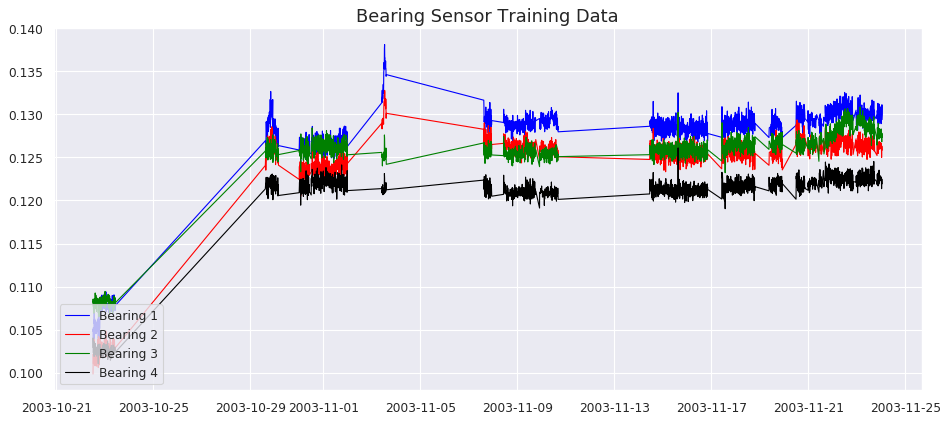

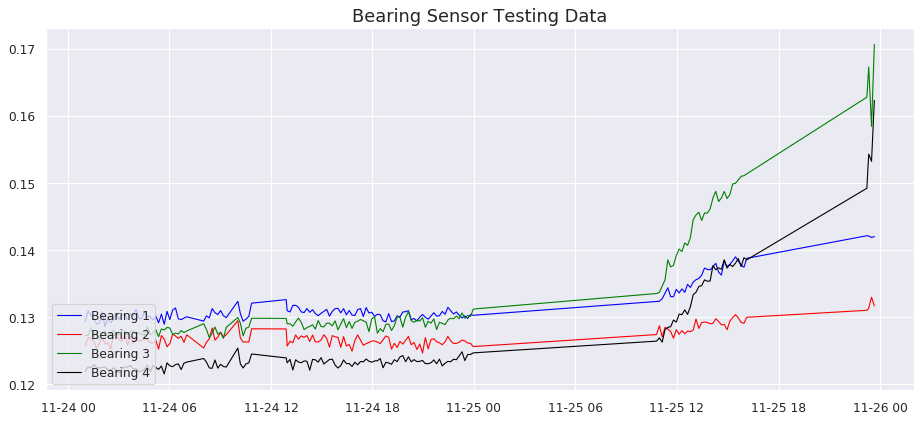

In [9]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Testing Data', fontsize=16)
plt.show()

**You can clearly see the anomaly occuring near the end of the testing data. We can transform this into the frequency domain for better visualization.**

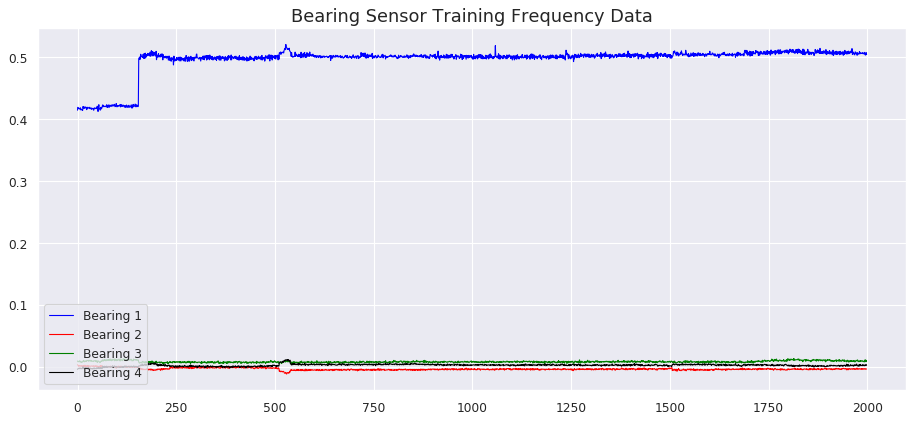

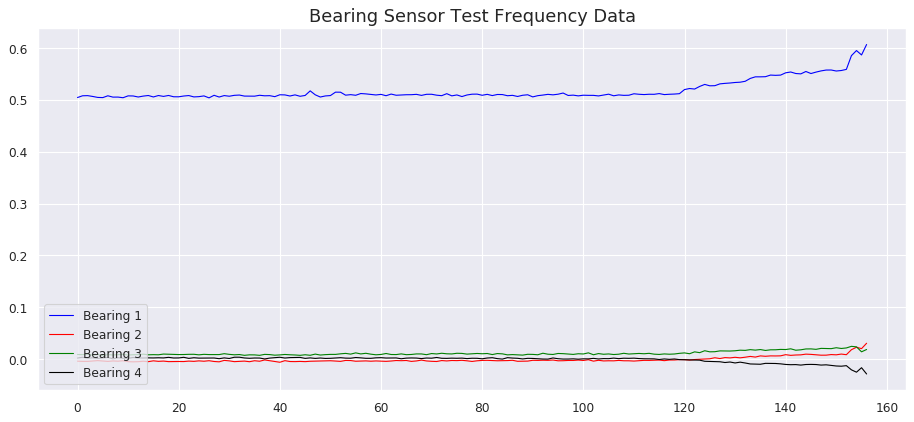

In [10]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

**Let's save the processed train and test data into csv files.**

In [11]:
import os 

data_dir = 'processed_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
train.to_csv(os.path.join(data_dir, 'train.csv'))
test.to_csv(os.path.join(data_dir, 'test.csv'))

### Upload and Register Dataset

Now we will start using Azure Machine Learning service, starting by registering our dataset. This will allow everyone in our workspace to use the dataset without having to go through the preparation up until this point in time.

**Connect to Azure ML Workspace**

In [12]:
from azureml.core import Workspace

workspace = Workspace.from_config()
datastore = workspace.get_default_datastore()

**Upload data to datastore**

In [13]:
datastore.upload(src_dir=data_dir, target_path='nasa-bearing')

Uploading an estimated of 2 files
Target already exists. Skipping upload for nasa-bearing/test.csv
Target already exists. Skipping upload for nasa-bearing/train.csv
Uploaded 0 files


$AZUREML_DATAREFERENCE_377a1ca5a4f94656916ae103506b81e2

**Register data as dataset**

In [14]:
from azureml.core import Dataset

nasa_dataset = Dataset.File.from_files(path=(datastore, 'nasa-bearing'))

nasa_dataset = nasa_dataset.register(workspace=workspace,
                                     name='NASA Bearing Dataset',
                                     description='Dataset containing NASA bearing signal readings.')

### Train LSTM Autoenoder Model

Now the that the dataset is registerd, we can use it to train an LSTM autoencoder model using Azure Machine Learning service.

**We have prepared a script which trains this model using Tensorflow 2.0. Run the code below to see the script.**

In [101]:
%pycat scripts/train.py

**Create a compute target for training**

In [15]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = 'k80cluster'
compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', 
                                                       idle_seconds_before_scaledown=6000,
                                                       min_nodes=0, 
                                                       max_nodes=2)

compute_target = ComputeTarget.create(workspace, cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True)

Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


**Create experiment**

In [16]:
from azureml.core import Experiment

experiment_name = 'nasa-bearing-anomaly-detection' 
experiment = Experiment(workspace, name=experiment_name)

**Submit training job**

In [32]:
from azureml.train.dnn import TensorFlow

estimator = TensorFlow(source_directory='training',
                       entry_script='train.py',
                       compute_target=compute_target,
                       script_params = {'--data_dir': nasa_dataset.as_named_input('nasabearing').as_mount()},
                       framework_version='2.0',
                       use_gpu=True,
                       pip_packages=['azureml-dataprep[fuse,pandas]==1.1.29', 'scikit-learn==0.22.1', 'seaborn==0.9.0'])

run = experiment.submit(estimator)

**Monitor submitted run**

In [33]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Evaluate Model

In the training scripts, we plotted the loss distribution on the training data which we can use to determine our anomaly detection threshold.

**Let's download and analyze the outputted plot**

In [34]:
run.download_file('./outputs/loss_distribution.png', output_file_path='loss_distribution.png')

(-0.5, 1279.5, 719.5, -0.5)

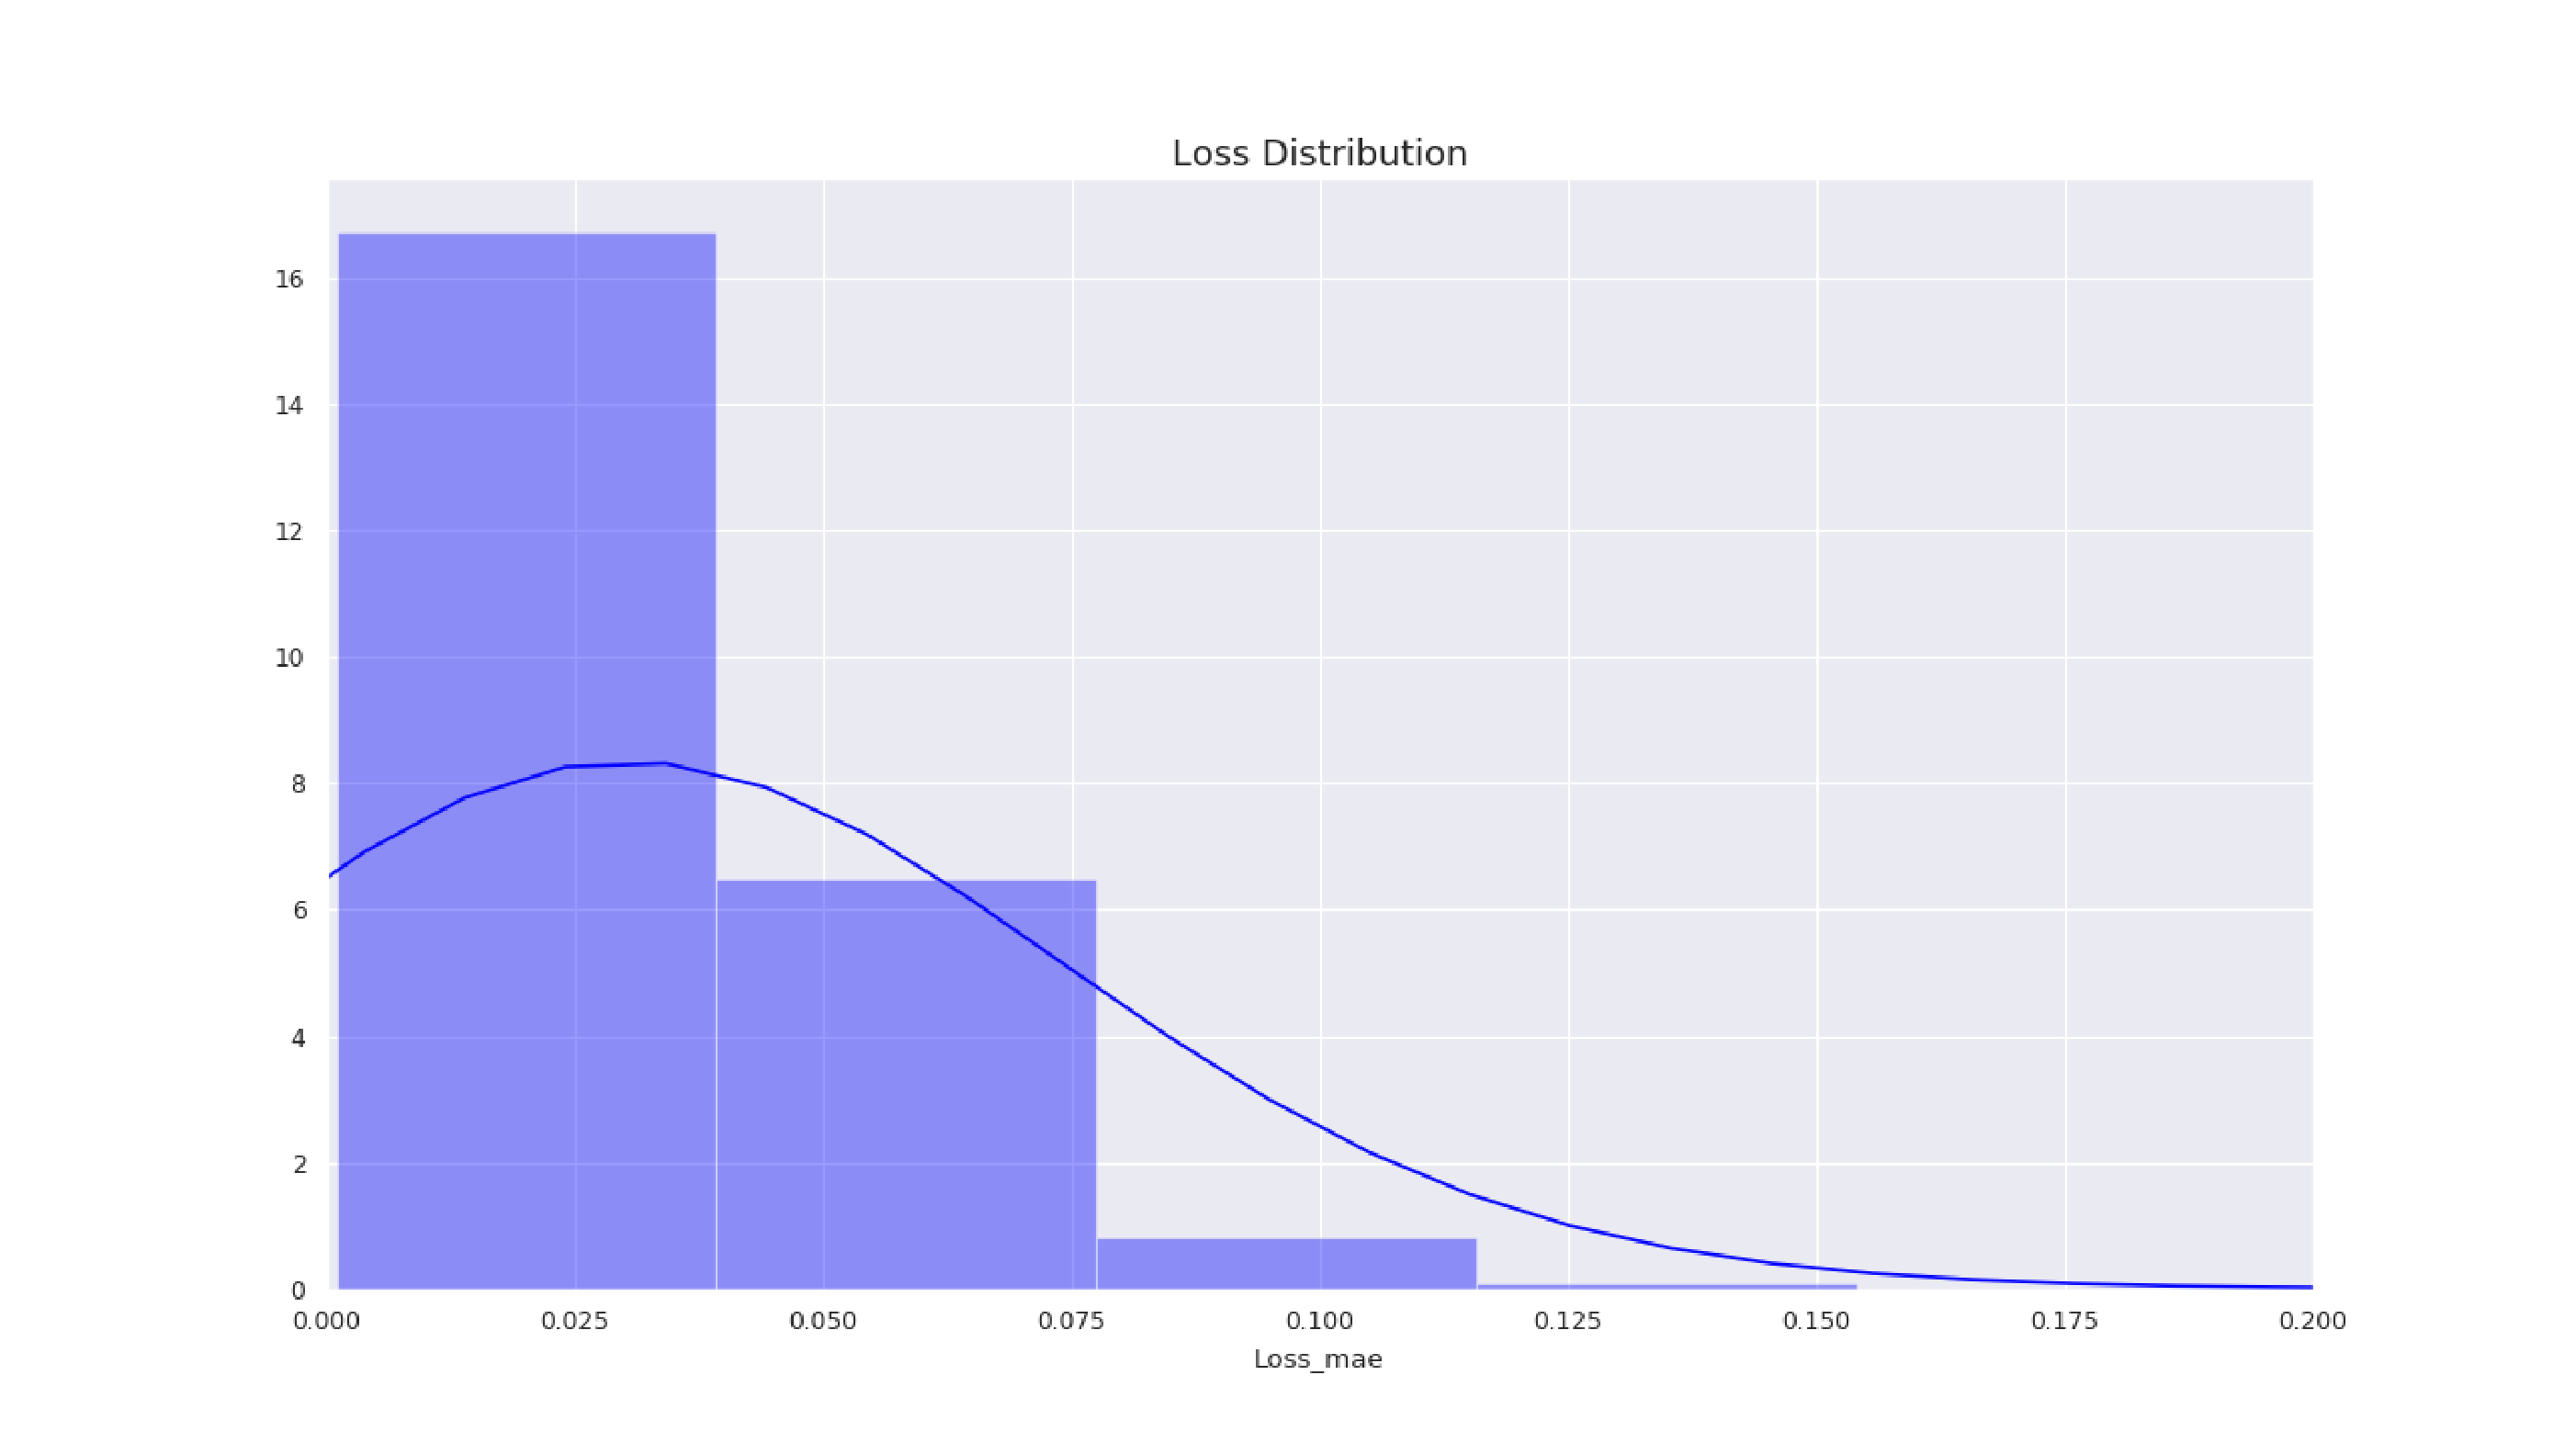

In [35]:
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('loss_distribution.png')
plt.figure(figsize = (50,40))
plt.imshow(image)
plt.axis('off')

**We want to use the above graph to determine a loss threshold for our anomaly detection. Knowing that sometimes the error can be due to noise and not actually anomaly, we want to select a threshold that is above the "noise level".**

**We will go with 0.150 as our threshold, where any loss greater than this will be flagged as an anomaly.**

### Register and Deploy Model

In order to replicate the real-life scenario of real time inferencing on the hardware itself, we will register and deploy the trained model as a web service. The service will take in time series data and return whether there is anomaly or not in the sequence by using the threshold of **0.7** determined above.

**Start by registering the model from the previous run.**

In [36]:
model = run.register_model(model_name='nasa-bearing-anomaly-prediction', model_path='outputs', description='Time series anomaly prediction on NASA Bearing dataset')

**A score.py and env.yml file has been created for the web service configuration. Run the lines below to see the content of the two files.**

In [237]:
%pycat deployment/score.py

In [238]:
%pycat deployment/env.yml

**Setup the configuration and deploy the web service.**

In [37]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(source_directory='deployment',
                                   runtime='python', 
                                   entry_script='score.py',
                                   conda_file='env.yml')

In [38]:
from azureml.core import Model 

model = Model(workspace, name='nasa-bearing-anomaly-prediction')

In [39]:
from azureml.core.webservice import Webservice
from azureml.exceptions import WebserviceException
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core import Model

aci_config = AciWebservice.deploy_configuration(cpu_cores=2, 
                                                memory_gb=4, 
                                                tags={'model': 'LSTM Autoencoder', 'method': 'tensorflow'}, 
                                                description='Performs anomaly detection on NASA Bearing dataset')

aci_service_name = 'nasa-bearing-anomaly-service'

try:
    aci_service = Webservice(workspace, name=aci_service_name)
    if aci_service:
        aci_service.delete()
except WebserviceException as e:
    print()

aci_service = Model.deploy(workspace, aci_service_name, [model], inference_config, aci_config)
aci_service.wait_for_deployment(True)

Running..........................
Succeeded
ACI service creation operation finished, operation "Succeeded"


### Test Service

Now that our service is deployed, we test out the service by sending in the testing sequence and seeing if an anomaly is detected and if so, when it it detected.

**Get the scoring url to our web service**

In [40]:
service_url = aci_service.scoring_uri

**Score the test sequence through the web service endpoint**

In [41]:
import pandas as pd
import requests
import json

# Load data
data_dir = 'processed_data'
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col=0)
test_data.index = pd.to_datetime(test_data.index, format='%Y-%m-%d %H:%M:%S')

# Send data through endpoint
input_data = json.dumps({'test_data': test_data.to_json()})
headers = {'Content-Type':'application/json'}
response = requests.post(service_url, input_data, headers=headers)

# Get response in pandas dataframe
result = pd.read_json(json.loads(json.loads(response.text))['result'])

**If we print the results of the predictions, you can see that an anomaly is detected beginning an 2003-11-25, at around 11:00 (varies slightly depending on the run)**

In [46]:
result.head(140)

,Loss_mae,Threshold,Anomaly
2003-11-24 01:01:24,0.026938,0.15,False
2003-11-24 01:11:24,0.053622,0.15,False
2003-11-24 01:21:24,0.058793,0.15,False
2003-11-24 01:31:24,0.044775,0.15,False
2003-11-24 01:41:24,0.036237,0.15,False
2003-11-24 01:51:24,0.025479,0.15,False
2003-11-24 02:01:24,0.053866,0.15,False
2003-11-24 02:11:24,0.036658,0.15,False
2003-11-24 02:21:24,0.033358,0.15,False
2003-11-24 02:31:24,0.031782,0.15,False


**Plotting out the data again, we can see that the sensors do indeed begin to degrade at the predicted time**

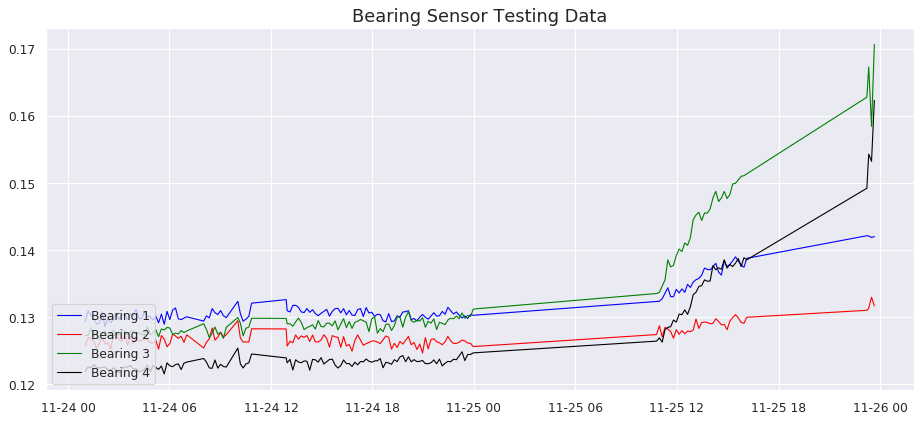

In [47]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_data['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_data['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_data['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_data['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Testing Data', fontsize=16)
plt.show()

**We can plot out the threshold that determines when the loss has reached a point of anomaly**

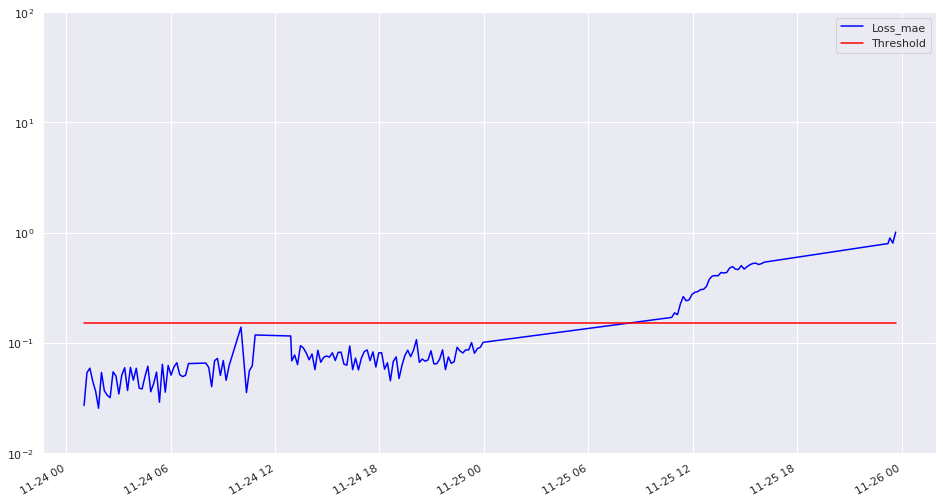

In [48]:
result.plot(logy=True, figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])